## Group 4

#### Team members:

Arngrímur Einarsson  
Guðmundur Orri Pálsson  
Nick Geerjens  
Stefán Gunnlaugur Jónsson  
Troy The Legend  



In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import math
import seaborn as sns; 
import copy
from pandas.plotting import parallel_coordinates
import random

In [2]:
data_test = pd.read_excel("HW3Avalidate.xlsx") 
data_train = pd.read_excel("HW3Atrain.xlsx")

X_train = data_train.copy()
X_train = X_train.drop('y', axis=1)
Y_train = data_train.copy()
Y_train = Y_train.drop('X_0', axis=1)
Y_train = Y_train.drop('X_1', axis=1)

X_test = data_test.copy()
X_test = X_test.drop('y', axis=1)
Y_test = data_test.copy()
Y_test = Y_test.drop('X_0', axis=1)
Y_test = Y_test.drop('X_1', axis=1)


x_0_min = min(X_train['X_0'])
x_0_max = max(X_train['X_0'])

x_1_min = min(X_train['X_1'])
x_1_max = max(X_train['X_1'])

for i in range(len(X_train['X_0'])):
    X_train['X_0'][i] = (X_train['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_train['X_1'][i] = (X_train['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max
    
for i in range(len(X_test['X_0'])):
    X_test['X_0'][i] = (X_test['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_test['X_1'][i] = (X_test['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max
'''
training_data = []
for i in range(len(X_train['X_0'])):
    training_data.append([round(X_train['X_0'][i], 2),round(X_train['X_1'][i],2)])
    
testing_data = []
for i in range(len(X_test['X_0'])):
    testing_data.append([round(X_test['X_0'][i],2),round(X_test['X_1'][i],2)])

y_train = []

for i in range(len(Y_train['y'])):
    y_train.append([Y_train['y'][i]])
    
y_test = []

for i in range(len(Y_test['y'])):
    y_test.append([Y_test['y'][i]])
'''

training_data = np.empty((0,2), int)
for i in range(len(X_train['X_0'])):
    training_data = np.append(training_data, np.array([[X_train['X_0'][i],X_train['X_1'][i]]]), axis=0)
    
testing_data = np.empty((0,2), int)
for i in range(len(X_test['X_0'])):
    testing_data = np.append(testing_data, np.array([[X_test['X_0'][i],X_test['X_1'][i]]]), axis=0)



y_train = np.empty((0,1), int)
for i in range(len(Y_train['y'])):
    y_train = np.append(y_train, np.array([[Y_train['y'][i]]]), axis=0)

y_test = np.empty((0,1), int)
for i in range(len(Y_test['y'])):
    y_test = np.append(y_test, np.array([[Y_test['y'][i]]]), axis=0)

np_testing_y = np.array(y_test)
np_testing_x = np.array(testing_data)
np_training_x = np.array(training_data)
np_training_y = np.array(y_train)


In [34]:
class Network_layer:
    
    def __init__(self, number_input, number_neurons, use_standard_activation, stand_dev):
        #self.size = size
        #self.weights = (np.random.rand(number_input,number_neurons)*2) - 1
        #self.weights = np.random.rand(number_input,number_neurons)
        self.weights = np.random.normal(0,stand_dev, number_input*number_neurons).reshape(number_input,number_neurons)
        self.bias = np.zeros(number_neurons)
        self.last_activation = None
        self.use_standard_activation = use_standard_activation
        self.error = None
        self.delta = None
        
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self.activation(r)
            
        return self.last_activation

    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def activation(self, x):
        #relu
        if self.use_standard_activation:
            x[x<0] = 0
            return x
        #tanh
        return self.tanh(x)
    
    def activation_derivative(self, x):
        #relu derivative
        if self.use_standard_activation:
            x[x>0] = 1
            x[x<0] = 0
            return x
        #tanh derivative
        return 1.0 - np.tanh(x)**2
    

class Neaural_net:
    neuron_idx = 0
    data_point_idx = 0
    heatmap_activations = np.zeros((len(np_testing_x),21))

    def make_zero(self):
        self.neuron_idx = 0
        self.data_point_idx = 0
        self.heatmap_activations = np.zeros((len(np_testing_x),21))
        
    layers = []
    
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def feed_forward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X

    def feed_forward_activation(self, X):
        for layer in self.layers:
            #print(layer.weights)
            X = layer.activate(X)
            #print(X)
            b = np.reshape(X, (1,np.product(X.shape)))[0]
            #print(b)
            for i in range(len(b)):
                self.heatmap_activations[self.data_point_idx][self.neuron_idx % 21] = b[i]
                self.neuron_idx = self.neuron_idx + 1
        return X
    
    def softmax(self,X):
        exps = np.exp(X)
        return exps / np.sum(exps)
    
    def cross_entropy(self, X,y):
        m = y.shape[0]
        p = self.softmax(X)
        
        likelihood = -np.log(p[range(m), y.argmax(axis=1)])
        loss = np.sum(likelihood) / m
        return loss
        
    def logloss(self, true_label, predicted, eps=1e-15):
        p = np.clip(predicted, eps, 1 - eps)
        if true_label == 1:
            return -math.log(p)
        else:
            return -math.log(1 - p) 
        
    def mae(self, targets, predictions):
        differences = predictions - targets
        absolute_differences = np.absolute(differences)
        mean_absolute_differences = absolute_differences.mean()
        return mean_absolute_differences
        
    def mean_squared_error(self, actual, predicted):
        sum_square_error = 0.0
        for i in range(len(actual)):
            sum_square_error += (actual[i] - predicted[i])**2.0
        mean_square_error = sum_square_error / len(actual)

        return mean_square_error
        
    def checkPrediction(self, y, pred):
        pred = np.around(pred)
        if pred == y:
            return 1
        else:
            return 0
               
        
    def backpropagation(self, X, y, learning_rate):
        output = self.feed_forward(X)
        average_activation = None
        correct_predictions = 0
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            all_deltas = []
            last_activations = []
            for j in range(len(output)):
                if layer == self.layers[-1]:
                    layer.error =  y[j] - output[j]
                    all_deltas.append(layer.error * layer.activation_derivative(output[j]))
                    last_activations.append(layer.activation_derivative(output[j]))
                    correct_predictions = correct_predictions + self.checkPrediction(y[j], output[j])
                else:
                    next_layer = self.layers[i + 1]
                    layer.error = np.dot(next_layer.weights, next_layer.delta)
                    all_deltas.append(layer.error * layer.activation_derivative(layer.last_activation[j]))
                    last_activations.append(layer.activation_derivative(layer.last_activation[j]))
                    
            average_delta = sum(all_deltas)/float(len(output))
            average_activation = sum(last_activations)/float(len(output))
            layer.delta = average_delta
    
        # Update the weights
        for j in range(len(output)):
            for i in range(len(self.layers)):
                layer = self.layers[i]
                input_to_use = np.atleast_2d(X[j] if i == 0 else self.layers[i - 1].last_activation[j])
                layer.weights += layer.delta * input_to_use.T * learning_rate
        return correct_predictions
            
    
    
    def get_batch(self, inputs, targets, batchsize, shuffle=False):
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.random.permutation(len(inputs))
        for start in range(0, len(inputs) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start:start + batchsize]
            else:
                excerpt = slice(start, start + batchsize)
            yield inputs[excerpt], targets[excerpt] 

            
    def train(self, X, y, learning_rate, max_epochs, batchsize):
        mses = []
        training_accuracy = []
        for i in range(max_epochs):
            correct_per_epoch = 0
            for x_batch,y_batch in self.get_batch(X,y,batchsize=batchsize,shuffle=False):
                correct_predictions_batch = self.backpropagation(x_batch,y_batch, learning_rate)
                correct_per_epoch = correct_per_epoch + correct_predictions_batch

            if i % 100 == 0:
                mse = np.mean(np.square(y - NN.feed_forward(X)))
                mses.append(mse)
                training_accuracy.append((correct_per_epoch/len(X))*100)
        return mses, training_accuracy 
    
    def test_activations(self, X, y_true):
        for i in range(len(X)):
            forward_pass = self.feed_forward_activation(X[i])
            self.data_point_idx = self.data_point_idx + 1
        return self.heatmap_activations
    
    
    def test(self, X, y_true):
        correct = 0
        TT = 0 
        TF = 0
        FT = 0
        FF = 0
        mses = []
        forward_passes = []
        y_truth_values = []
        for i in range(len(X)):
            forward_pass = self.feed_forward(X[i])
            forward_passes.append(forward_pass)
            pred = np.around(forward_pass)
            y = y_true[i]
            y_truth_values.append(y)
            if pred == y:
                correct = correct + 1
            if pred == 1 and y == 1:
                TT = TT + 1
            if pred == 1 and y == 0:
                FT = FT + 1
            if pred == 0 and y == 1:
                FF = FF + 1
            if pred == 0 and y == 0:
                TF = TF + 1
            confusion = [TT, TF, FT, FF]
        mse = np.mean(np.square(np.array(y_truth_values) - np.array(forward_passes)))
        mses.append(mse)
        return correct/len(X), confusion, mses
    
    def test_q4(self, X, y_true):
        y_truth_values = []
        for i in range(len(X)):
            forward_pass = self.feed_forward(X[i])
            pred = np.around(forward_pass)
            y_truth_values.append(pred)
        return y_truth_values

    
    
def should_break(last_mse, mses, lowest_mse):
    stop = False
    mse_same = True
    for i in range(len(last_mse)):
        if round(last_mse[i],4) != round(mses[0],4):
            mse_same = False
    if mse_same:
        print("MSE has converged!")
        stop = True
    if round(mses[0], 3) < 0.07:
        print("Error is sufficiently low!")
        stop = True
    if round(mses[0],4) - lowest_mse > 0.05:
        print("MSE increased!")
        stop = True
    return stop





def run_training(NN, learning_rate = 0.009, batchsize = 5, number_test = 10, number_epoc = 35):
    # Train the neural networks
    accuracy = []
    iteration = []
    total_error = []
    total_mses = []
    total_training_accuracy = []
    last_mse = [0,0,0,0,0]
    a = 0
    total_time = 0
    max_accuracy = 0
    best_NN = copy.copy(NN)
    best_confusion = [0,0,0,0]
    best_learning_rate = learning_rate
    recall = []
    precision = []
    lowest_mse = 100
    
    for i in range(1,number_test+1):
        start = time.time()
        errors, training_accuracy = NN.train(np_training_x, np_training_y, learning_rate, number_epoc, batchsize)
        end = time.time()
        total_time = total_time + (end-start)
        total_error.append(errors)
        total_training_accuracy.append(training_accuracy)
        iteration.append(i*number_epoc)
        accuracy_one, confusion, mses = NN.test(np_testing_x, np_testing_y)
        total_mses.append(mses)
        last_mse[a] = round(mses[0],4)
        a = a + 1
        if a > 4:
            a = 0

        if(accuracy_one > max_accuracy):
            max_accuracy = copy.copy(accuracy_one)
            best_NN = copy.deepcopy(NN)
            best_confusion = copy.copy(confusion)
            best_learning_rate = copy.copy(learning_rate)
        if mses[0] < lowest_mse:
            lowest_mse = mses[0]
        accuracy.append(accuracy_one*100)
        #if should_break(last_mse, mses, lowest_mse):
        #    break;
        #learning_rate = learning_rate*0.97
    '''
    #print('Training accuracy-iteration: %.2f%%' % (training_accuracy[-1]))
    #print('Testing accuracy-iteration: %.2f%%' % (accuracy_one*100), "Learning rate --> "+ str(learning_rate))
    #print('Confusion matrix ---> TrueOne:',confusion[0] ,'TrueZero:',confusion[1], 'FalseOne:',confusion[2] , 'FalseZero',confusion[3] )
    #print("MES: ", mses[0])
    #print()
    #print("Average training time for network running " + str(number_epoc) + " iterations with batch size " + str(batchsize) + " --->" + str(total_time/number_test)+ "s")
    plt.plot(iteration,accuracy, label='Validation accuracy')
    #plt.plot(iteration, total_error, label='Mean squared error for training set')
    #plt.plot(iteration, total_mses, label='Mean squared error for validation set')
    plt.plot(iteration, total_training_accuracy, label='Training accuracy')
    #plt.plot(iteration, recall, label='Recall')
    #plt.plot(iteration, precision, label='Precision')
    plt.xlabel('iterations')
    plt.ylabel('Accuracy & MSE(*100)')
    plt.axis((number_epoc,number_epoc*number_test,0,100))
    plt.title('')
    plt.legend(loc='best')
    plt.show()
    '''



    accuracy_one, confusion, mses = best_NN.test(np_testing_x, np_testing_y)
    #print("------------------------")
    #print('Accuracy-best: %.2f%%' % (accuracy_one*100), "Learning rate --> "+ str(best_learning_rate))
    #print('TrueOne:',confusion[0] ,'TrueZero:',confusion[1], 'FalseOne:',confusion[2] , 'FalseZero',confusion[3] )
    #print()
    return accuracy_one*100


def init_net(hidden_layers, stand_devation):
    NN = Neaural_net()
    NN.add_layer(Network_layer(2, 10, False, stand_devation))
    for i in range(hidden_layers - 1):
        NN.add_layer(Network_layer(10, 10, False, stand_devation))
    NN.add_layer(Network_layer(10,1, False, stand_devation))
    return NN

def init_net_q4(hidden_layers, stand_devation, neurons = 10):
    NN = Neaural_net()
    NN.add_layer(Network_layer(2, neurons, False, stand_devation))
    for i in range(hidden_layers - 1):
        NN.add_layer(Network_layer(neurons, neurons, False, stand_devation))
    NN.add_layer(Network_layer(neurons,1, False, stand_devation))
    return NN

def question4():
    NN = init_net(2,0.4,neurons = 10)
    #pred = NN.test_q4(np_testing_x, np_testing_y)
    #print(pred)
    
    
    plt.figure()

    pd.plotting.parallel_coordinates(
        data_test[['X_0', 'X_1', 'y']], 
        'y', color=['g','r'])

    #X_test['X_0']
    plt.show()
    
    
#question4()


alphas = [0.001, 0.01, 0.05, 0.1]
amount_of_layers = [2, 3, 4]
amount_of_neurons = [5, 10, 15, 20]
batch_size = [1, 2, 5, 10, 20]
deviation = [0.1, 0.3, 0.6, 1]


'''
alphas = [0.001]
amount_of_layers = [2]
amount_of_neurons = [5, 10]
batch_size = [1, 2]
deviation = [0.1, 0.3]
'''


a = []
b = []
c = []
d = []
e = []
acc = []
accuracy = []

for i in alphas:
    for j in amount_of_layers:
        for k in amount_of_neurons:
            for h in batch_size:
                for f in deviation:
                    if random.random() < 0.01:
                        NN = init_net_q4(j,f,k)
                        accuracy = run_training(NN, learning_rate = i, batchsize = h)
                        a.append(i)
                        b.append(j)
                        c.append(k)
                        d.append(h)
                        e.append(f)
                        acc.append(accuracy/100)
                        print(i, j, k, h, f, accuracy)

data_q4 = {
        'alpha': a, 
        'layers': b, 
        'neurons': c,
        'batch': d,
        'deviation': e, 
        'accuracy': acc,
       } 
  
# Convert the dictionary into DataFrame 
df = pd.DataFrame(data_q4)
                             
                    

0.001 2 10 20 0.6 62.19512195121951
0.001 2 20 2 0.1 58.536585365853654
0.001 3 20 10 0.3 59.756097560975604
0.001 4 5 2 0.6 87.8048780487805
0.01 2 20 10 0.3 60.97560975609756
0.01 2 20 20 0.3 62.19512195121951
0.01 4 10 10 1 74.39024390243902
0.01 4 20 2 1 90.2439024390244
0.05 4 15 10 0.3 64.63414634146342


In [36]:
import plotly.graph_objects as go

import pandas as pd

#colorscale = [[0,'purple'],[0.5,'lightseagreen'],[1,'gold']],
print(df['accuracy'])
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['accuracy'],
                    cmin = 0.5,
                    cmax = 1,
                    showscale = True,
                    colorscale = [[0,'purple'],[0.5,'lightseagreen'],[1,'gold']]
                   ),
        dimensions = list([
            dict(range = [0,0.1],
                #constraintrange = [4,8],
                label = 'alpha', values = df['alpha']),
            dict(range = [2,4],
                label = 'layers', values = df['layers']),
            dict(range = [5,20],
                label = 'neurons', values = df['neurons']),
            dict(range = [1,20],
                label = 'batch', values = df['batch']),
            dict(range = [0.1,1],
                label = 'deviation', values = df['deviation'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

0    0.621951
1    0.585366
2    0.597561
3    0.878049
4    0.609756
5    0.621951
6    0.743902
7    0.902439
8    0.646341
Name: accuracy, dtype: float64


## 1. (10 points) Parameter initialization. 

Choose the best performing model from HW3A in termsof classification accuracy. For this model, initialize all its parameters (connection weights and biases) to zero and retrain it using all the other settings from HW3A. Report the performance (e.g.loss function over training epochs, classication accuracy and confusion matrix on the validation set after training) of this new trained model. Do you observe any interesting behavior for this
new trained model? Discuss the performance of this new trained model in comparison with the
performance of the best model from HW3A.

Our accuracy is stuck at $50\%$ when the weights and bias are initialized to zero. In each iteration of the backpropigation, we update the weights by multiplying the existing weight by a delta determined by backpropagation. If the initial weights value are zeros, multiplying it by any value for delta won't change the weight which means each iteration has no effect on the weights you're trying to optimize.



## 2. (10 points) Learning rate vs parameter initialization. 

Retrain several times for the same fixed amount of epochs (e.g. 100 - this value is your choice) the best model from HW3A using exactly the same settings as in HW3A, with the exception of the learning rate and the initialization of the connection weights and biases which have to be different for each retraining. Start with a very small learning rate (e.g. 0:0001) and after that gradually increase it (e.g. next values can be
:001, 0:01, ...). Initialize the connection weights and biases by sampling from a normal distribution
$N(0, \sigma^2)$ has to take the following values $\{0; 0.1; 0.2; 0.3; 0.4; 0.5; 0.6; 0.7; 0.8; 0.9; 1\}$. Make a heatmap where the x-axis represents $\sigma^2$, the y-axis represents the learning rate, while the colors
represent the accuracy obtained on the validation set after each training. Each element in the
heatmap matrix represents practically the accuracy obtained with a specific learning rate and a
specific initialization. Discuss the heatmap results.

In [ ]:
stand_dev = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#stand_dev = [0, 0.1, 0.2, 0.3]
learning_alphas = [0.0001, 0.001, 0.01, 0.05, 0.1]
#learning_alphas = [0.0001, 0.001]
accuracy = np.zeros((len(learning_alphas),len(stand_dev)))
for i in range(len(learning_alphas)):
    for j in range(len(stand_dev)):
        NN = init_net(2,stand_dev[j])
        accuracy[i][j] = run_training(NN, learning_rate = learning_alphas[i])
        print('learning rate: ', learning_alphas[i])
        print('stand_dev: ', stand_dev[j])
        print('accuracy', accuracy[i][j])
        print()

sns.heatmap(accuracy)

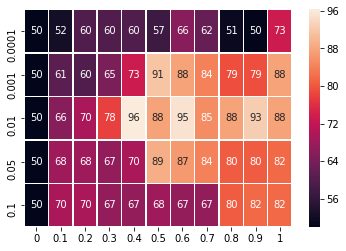

In [24]:
x_axis_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # labels for x-axis
y_axis_labels = [0.0001, 0.001, 0.01, 0.05, 0.1] # labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(accuracy, linewidths=.5, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

We can see that the best/highest accuracy can be fount in the middle. This is where neither the learning_rate nor the weigth initialization are too extreme. Our best results are where the learning rate $\alpha=0.1$ and standard deviation from $\sigma=0.4$ to $\sigma= 0.6$. When the learning rate is too low the algorithm either takes a long time to train or it can get stuck in a local extremum in the training data. When it is too big it has a trouble training because it overshoots the minumum and never quite gets to the optimal place.  
As seen in part 1, when we initialize the weights to 0 we dont get good results. It is the same when we are close to zero, the training gets stuck or the weights just don´t respond to the training. When the weights are too big take a longer time to train. 


# 3. (10 points) Activations. 
Choose the worst (one which still trains and does not give errors during
training) and the best performing models from Subproblem 2 in terms of classication accuracy.
For both models, visualize the hidden neurons activations for each of the two hidden layer three
times (after connection initialization before to start the training process, at half of the training
process, and at the end of the training process). Visualization hints (it is optional to follow them,
please feel free to be creative): you can compute the activations on the validation set where the
data points are ordered per class; you can use a heatmap where x-axis represents the hidden neuron
id, the y-axis represents the data points id, and the colors represent the activations. Discuss the
results.

Good model
89.02439024390245 %
Bad model
68.29268292682927 %


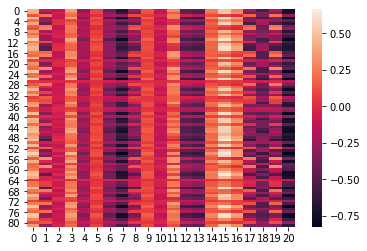

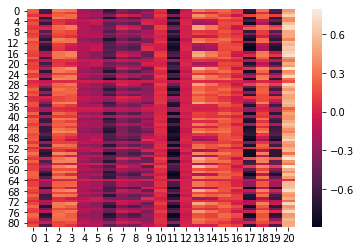

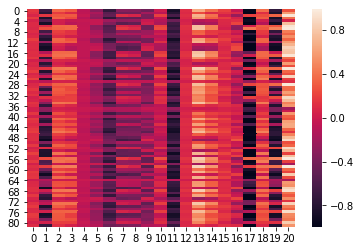

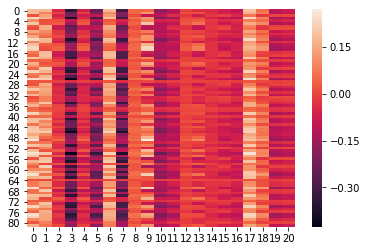

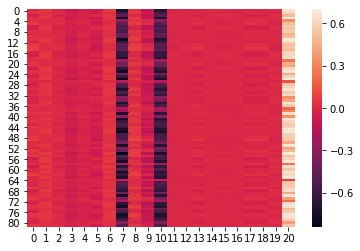

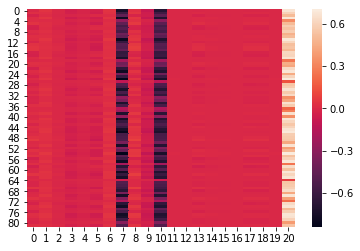

In [71]:
def question3(dist, alpha):
    NN = init_net(2,dist)
    heat_map = NN.test_activations(np_testing_x, np_testing_y)
    fig = plt.figure()
    sns.heatmap(heat_map)
    NN.make_zero()
    run_training(NN, number_test = 10, learning_rate = alpha)
    heat_map1 = NN.test_activations(np_testing_x, np_testing_y)
    fig2 = plt.figure()
    sns.heatmap(heat_map1)
    NN.make_zero()
    acc = run_training(NN, number_test = 10, learning_rate = alpha)
    heat_map2 = NN.test_activations(np_testing_x, np_testing_y)
    fig3 = plt.figure()
    sns.heatmap(heat_map2)
    print(acc, "%")
    #print(heat_map)

print("Good model")
question3(0.4, 0.01)
print("Bad model")
question3(0.2, 0.05)

# 4. (20 points) Hyperparameters Optimization. 
On the dataset from HW3A please train a MLP model on which you perform hyperparameters optimization. For this specific subproblem, you are not constraint anymore to use just two hidden layers, and 10 neurons per hidden layer. You are free to vary any hyperparameter (e.g. learning rate, number of hidden neurons per layer, type of activation function) you consider to be important to maximize the accuracy on the validation set. Please make a Parallel Coordinates Plot to study the effect of the hyperparameters choice on the performance.
The colors of the lines which connect various hyperparameter settings represent the accuracy on
the validation set. Discuss the results. For the worst and best performing models, please make
a plot with the values of the loss function computed separately over the training and validation
sets respectively. Discuss the generalization performance (non exclusive suggestions: overfitting,
underfitting) of these two extreme models.

## II. Peer Review paragraph (0 points)
Finally, each group member must write a single paragraph outlining their opinion on the work distri- bution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?